In [1]:
!pip install -q zenodo_get

  Preparing metadata (setup.py) ... done


In [2]:
! zenodo_get -d 10.5281/zenodo.7786311

Title: Numerical simulations and experimental measurements of the ULB semi-industrial furnace for the development of a Digital Twin
Keywords: Digital Twin, Flameless combustion, Furnace, CFD, Temperature measurements
Publication date: 2023-08-30
DOI: 10.5281/zenodo.8300372
Total size: 748.7 MB

Link: https://zenodo.org/api/files/90435c77-6765-4d50-b5c2-96155fcc0c6a/DT_dataset.zip   size: 748.7 MB

Checksum is correct. (c9aeb72b44088a7cc53c7470d3d435f6)
All files have been downloaded.


In [3]:
! unzip DT_dataset.zip

Archive:  DT_dataset.zip
   creating: DT_dataset/
   creating: DT_dataset/Numerical_data/
  inflating: __MACOSX/DT_dataset/._Numerical_data  
  inflating: DT_dataset/.DS_Store    
  inflating: __MACOSX/DT_dataset/._.DS_Store  
  inflating: DT_dataset/grid.vtu     
  inflating: __MACOSX/DT_dataset/._grid.vtu  
  inflating: DT_dataset/cases_parameters.csv  
  inflating: __MACOSX/DT_dataset/._cases_parameters.csv  
  inflating: DT_dataset/README.txt   
  inflating: __MACOSX/DT_dataset/._README.txt  
   creating: DT_dataset/Experimenta_data/
  inflating: DT_dataset/Numerical_data/Case44_20mm_0_17_H2_0_73phi_end_nox  
  inflating: DT_dataset/Numerical_data/Case37_25mm_0_65H2_0_84phi_end_nox  
  inflating: DT_dataset/Numerical_data/Case31_16mm_0_60H2_0_75phi_end_nox  
  inflating: DT_dataset/Numerical_data/Case22_20mm_0_8H2_0_82phi_end_nox  
  inflating: DT_dataset/Numerical_data/Case7_20mm_0_45_H2_0_72phi_end_nox  
  inflating: DT_dataset/Numerical_data/Case12_16mm_0_60H2_0_93phi_end_nox  


In [ ]:
! pip install openmeasure

In [4]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import pyvista as pv
else:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista as pv

--2023-09-12 14:58:22--  https://fem-on-colab.github.io/releases/vtk-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1698 (1.7K) [application/x-sh]
Saving to: ‘/tmp/vtk-install.sh’

/tmp/vtk-install.sh 100%[===================>]   1.66K  --.-KB/s    in 0s      

2023-09-12 14:58:22 (15.5 MB/s) - ‘/tmp/vtk-install.sh’ saved [1698/1698]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ VTK_INSTALLED=/usr/local/share/fem-on-colab/vtk.installed
+ [[ ! -f /usr/local/share/fem-on-colab/vtk.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/92286a0/releases/h5py-install.sh
+ [[ https://github.com/

In [6]:
import pandas as pd
import panel

panel.extension("vtk")

path = './DT_dataset'
mesh = pv.read(f'{path}/grid.vtu')

sim_path = f'{path}/Numerical_data/Case6_25mm_0_70H2_0_94phi_end_nox'
sim_df = pd.read_csv(sim_path)

mesh['temperature'] = sim_df.iloc[:, -1] # temperature

panel_plotter = pv.Plotter(notebook=True)
panel_plotter.add_mesh(mesh, scalars='temperature')
panel_plotter._on_first_render_request()
panel.panel(
    panel_plotter.render_window, orientation_widget=panel_plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode="stretch_width"
)


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='d2c...], sizing_mode='stretch_width')

In [7]:
import numpy as np
import glob
from scipy.interpolate import griddata

def read_simulation(filepath):
    sim = np.array(pd.read_csv(filepath))
    xyz = np.array(sim[:,1:4])

    column = np.empty((n, ))
    for i, f in enumerate(features):
        if xyz.shape[0] != n_cells:
            column[i*n_cells:(i+1)*n_cells] = griddata(xyz, sim[:,4+i], xyz_25, method='nearest')
        else:
            column[i*n_cells:(i+1)*n_cells] = sim[:,4+i]

    return column

P_df = pd.read_csv(f'{path}/cases_parameters.csv')
P = np.array(P_df.iloc[:,2:])
m = P.shape[0]

features = ['NOx', 'CO', 'OH', 'H2', 'H2O', 'CO2', 'O2', 'CH4', 'T']
n_features = len(features)

# The simulations with different inlet diameter use different grids.
# We interpolate them on the coarsest grid, which is the one for D=25mm.

filepath = glob.glob(f'{path}/Numerical_data/Case6_*')
xyz_25 = np.array(pd.read_csv(filepath[0]).iloc[:,1:4])
n_cells = xyz_25.shape[0]

n = n_features*n_cells
X = np.empty((n,m))
for i in range(P_df.shape[0]):
    filepath =  glob.glob(f'{path}/Numerical_data/Case{P_df.iloc[i,1]}_*')
    X[:,i] = read_simulation(filepath[0])
    print(f'\r Simulation {i+1}/{m}', end='', flush=True)

 Simulation 45/45

In [8]:
! pip install openmeasure

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 57.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 16.0 MB/s eta 0:00:00
  Created wheel for openmdao: filename=openmdao-3.28.0-py3-none-any.whl size=6192819 sha256=7eb9a4310d9b7b838e55d539ccf64ad3c6896d9622b8996491431da228defb7b
  Stored in directory: /root/.cache/pip/wheels/a1/85/e8/4861569b8d3965486e4108cd2876c987b43bcd1b1a5ad1ea68
Successfully built openmdao
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requir

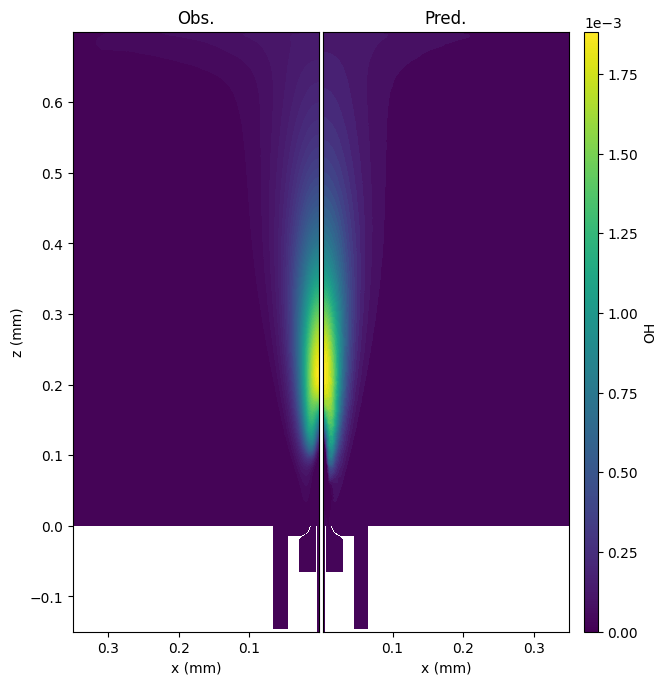

In [9]:
from gpr import GPR
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_comparison(mesh, zs, normal, origin, axis, feature, cmap='viridis'):
    n_cases = len(zs)
    cases = ['Obs.', 'Pred.']
    for i, case in enumerate(cases):
        mesh[case] = zs[i]

    plane = mesh.ctp().slice(normal=normal, origin=origin, generate_triangles=True)

    vmin = plane[cases[0]].min()
    vmax = plane[cases[0]].max()

    extent_min = [-0.2, -0.2, 0.1]
    extent_max = [0.2, 0.2, 0.5]

    x = plane.points
    tri = plane.faces.reshape((-1,4))[:, 1:]

    fig, axs = plt.subplots(ncols=n_cases, figsize=(5.4, 6))
    levels = 64

    axis_labels = ['x', 'y', 'z']
    fig.subplots_adjust(bottom=0., top=1., left=0, right=.925, wspace=0.0, hspace=0.05)

    for i, ax in enumerate(axs):
        if i == 0:
            ax.invert_xaxis()

        cs = ax.tricontourf(x[:,axis[0]], x[:,axis[1]], tri, plane[cases[i]], cmap=cmap,
                        vmin=vmin, vmax=vmax, levels=levels)

        ax.set_aspect('equal')
        ax.set_xlabel(f'{axis_labels[axis[0]]} (mm)')
        ax.set_title(cases[i])

        if i > 0:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        else:
            ax.set_ylabel(f'{axis_labels[axis[1]]} (mm)')


    ax_bounds = axs[1].get_position().bounds
    cb_ax = fig.add_axes([0.95, ax_bounds[1], 0.025, ax_bounds[3]])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cb_ax, orientation='vertical', label=feature)
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((0, 4))
    cb_ax.yaxis.set_offset_position('left')

    plt.show()

i_test = [0, 21, 27, 38] # index of the testing simulations

P_train = np.delete(P, i_test, axis=0)
P_test = P[i_test, :]

X_train = np.delete(X, i_test, axis=1)
X_test = X[:, i_test]

# Create the gpr object
gpr = GPR(X_train, n_features, xyz_25, P_train)

# Calculates the POD coefficients ap and the uncertainty for the test simulations
models, likelihoods = gpr.fit(verbose=False)
Ap, Sigmap = gpr.predict(P_test)

# Reconstruct the high-dimensional state from the POD coefficients
Xp = gpr.reconstruct(Ap)

# Select the feature to plot
str_ind = 'OH'
ind = features.index(str_ind)

x_test = X_test[ind*n_cells:(ind+1)*n_cells,3]
xp_test = Xp[ind*n_cells:(ind+1)*n_cells, 3]

plot_comparison(mesh, [x_test, xp_test], (0,1,0), (0.0, 1.0e-3, 0), (0,2), 'OH')